In [920]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.integrate import odeint
from scipy import constants

In [921]:
# Conditions
V0 = 750 # Vmax (V)
f0 = 50000 # RF frequency (Hz)
w0 = 2 * np.pi * f0 # Angular frequency
dgap = 2e-4 # gap length (m)
ddiel = 1e-4 # dielectric thickness (m)
dplate = 0.1 # Plate diameter (m)
As = 0.25 * np.pi * dplate**2 # Plate area (m2)

In [922]:
# Parameters
epsr = 10 # relative permittivity
eps0 = 8.8541878128e-12 # vacuum permittivity (F/m)
type_EEDF = 1 # 1:Maxwellian EEDF, 2:Druyvesteyn EEDF, 1~2: Generalized EEDF
me = constants.electron_mass # electron mass (kg)
qe = constants.elementary_charge # electron charge (C)
NA = constants.Avogadro # Avogadro number (1/mol)

In [923]:
# Electron Collision Reaction Source Treatment
with open('Ar_xsecs.txt', 'r') as file:
    data = file.read()
    file.close()

In [924]:
# Cross-section area Data Generation
rawD = data.split('\n')
rawD = [x for x in rawD if x != '']

reaction_index = []
for i in range(len(rawD)):
    if rawD[i].startswith('Type'):
        reaction_index.append(i)

R_type = list(range(len(reaction_index)))
R_eqn = list(range(len(reaction_index)))
R_Eloss = list(range(len(reaction_index)))
R_ext = list(range(len(reaction_index)))
R_Elevel = []
R_crossA = []
for i, name in enumerate(reaction_index):
    R_type[i] = rawD[name].split(' ')[1]
    R_eqn[i] = rawD[name+1]
    R_Eloss[i] = float(rawD[name+2].split(' ')[0])
    if R_type[i] == 'EXCITATION':
        R_ext[i] = float(rawD[name+2].split(' ')[2])
    else:
        R_ext[i] = 0
    if i != len(reaction_index) - 1:
        data_range = list(range(reaction_index[i]+5,reaction_index[i+1]-1))
        Elevel = list(range(len(data_range)))
        crossA = list(range(len(data_range)))
        iteration = 0
        for j in data_range:
            Elevel[iteration] = float(rawD[j].split(' ')[2])
            crossA[iteration] = float(rawD[j].split(' ')[4])
            iteration += 1
        R_Elevel.append(np.array(Elevel))
        R_crossA.append(np.array(crossA))
    else:
        data_range = list(range(reaction_index[i]+5,len(rawD)-1))
        Elevel = list(range(len(data_range)))
        crossA = list(range(len(data_range)))
        iteration = 0
        for j in data_range:
            Elevel[iteration] = float(rawD[j].split(' ')[2])
            crossA[iteration] = float(rawD[j].split(' ')[4])
            iteration += 1
        R_Elevel.append(Elevel)
        R_crossA.append(crossA)


In [925]:
# Cross-section area interpolation function
from scipy import interpolate
def create_cross_section_interpolator(Elevel,crossA):
    def non_negative_interp(x):
        return np.maximum(0, interpolate.interp1d(Elevel, crossA, kind='cubic', fill_value='extrapolate')(x))
    return non_negative_interp

R_cross_interpolator = list(range(len(reaction_index)))
for i in range(len(reaction_index)):
    R_cross_interpolator[i] = create_cross_section_interpolator(R_Elevel[i],R_crossA[i])

def calculate_cross_section(interpolator, energy):
    return interpolator(energy)

In [926]:
# upper incomplete gamma function
from scipy import special

def upper_incomplete_gamma(a):
    return special.gamma(a)

# EEDF calculation
def calculate_EEDF(type_EEDF,E,E_mean):
    g = type_EEDF
    beta1 = (upper_incomplete_gamma(5/(2*g)))**(3/2)*(upper_incomplete_gamma(3/(2*g)))**(-5/2)
    beta2 = upper_incomplete_gamma(5/(2*g))*upper_incomplete_gamma(3/(2*g))**(-1)
    return g*beta1*E_mean**(-3/2)*np.exp(-(E*beta2/E_mean)**g)

In [927]:
e_grid = np.arange(0,100,0.01)

In [928]:
# Rate Expression
def Rate_coeff(E_mean):
    R_coeff = list(range(len(R_Elevel)))
    for i in range(len(R_coeff)):
        EEDF = calculate_EEDF(type_EEDF,e_grid, E_mean)
        crossA = calculate_cross_section(R_cross_interpolator[i],e_grid)
        R_coeff[i] = np.sqrt(2 * qe / me) * np.trapz(EEDF * crossA * e_grid,e_grid)
    return R_coeff


In [929]:
# Detailed Balance for de-excitation process
index_excitation = [i for i, name in enumerate(R_type) if name == 'EXCITATION']
for i in index_excitation:
    eloss = R_Eloss[i]
    e = R_Elevel[i] - eloss + 1e-15
    sig = calculate_cross_section(R_cross_interpolator[i],R_Elevel[i])
    R_type.append('DE-EXCITATION')
    R_Elevel.append(e)
    R_crossA.append(1/R_ext[i]*(e+eloss)/e*sig)
    R_Eloss.append(-eloss)
    R_eqn.append(f'(rev){R_eqn[i]}')

iter = list(range(len(reaction_index),len(R_eqn)))

for j in iter:
    R_cross_interpolator.append(create_cross_section_interpolator(R_Elevel[j],R_crossA[j]))

In [930]:
# Gas Phase Reaction
k_gas = []
# Ars + Ars => e + Ar + Ar+
R_type.append('Pooling')
R_eqn.append('Ars+Ars=>e+Ar+Ar1p')
R_Eloss.append(0)
k_gas.append(337340000/NA) # forward rate constant (m3/s/mol)
# Ars + Ars => e + Ar + Ar+
R_type.append('Quenching')
R_eqn.append('Ars+Ar=>Ar+Ar')
R_Eloss.append(0)
k_gas.append(1807/NA) # forward rate constant (m3/s/mol)

In [931]:
print(len(R_eqn))
print(len(Rate_coeff(5)))

7
5


In [932]:
def calculate_reaction_rates(R_eqn, k, concentrations):
    reaction_rates = []
    for i, eqn in enumerate(R_eqn):
        # 반응물과 생성물 분리
        reactants, products = eqn.split('=>')
        if 'rev' in reactants:
            reactants = products
        # 반응 속도 계산
        rate = k[i]
        for reactant in reactants.split('+'):
            reactant = reactant.strip()
            if reactant == 'e':
                rate *= concentrations['e']
            elif reactant == 'Ar':
                rate *= concentrations['Ar']
            elif reactant == 'Ars':
                rate *= concentrations['Ars']
            elif reactant == 'Ar1p':
                rate *= concentrations['Ar1p']
        
        reaction_rates.append(rate)
    
    return reaction_rates

In [933]:
R_eqn

['e+Ar=>e+Ar',
 'e+Ar=>e+Ars',
 'e+Ar=>2e+Ar1p',
 'e+Ars=>2e+Ar1p',
 '(rev)e+Ar=>e+Ars',
 'Ars+Ars=>e+Ar+Ar1p',
 'Ars+Ar=>Ar+Ar']

In [934]:
# plasma model
def model(y, t):
    n_e, n_Ar, n_Ars, n_Ar1p, E_mean, Q_diel = y

    # calculate the voltage and electric field
    V_applied = V0 * np.sin(w0 * t)
    V_diel = Q_diel / (eps0 * epsr * As / ddiel)
    V_gap = V_applied - 2 * V_diel
    E = V_applied / dgap

    conc = {
        'e': n_e,
        'Ar': n_Ar,
        'Ars': n_Ars,
        'Ar1p': n_Ar1p
    }
    # reaction rate
    r = calculate_reaction_rates(R_eqn, Rate_coeff(E_mean)+k_gas,conc)

    # mass balance
    dn_e_dt = r[2] + r[3] + r[5]
    dn_Ar_dt = -r[1] - r[2] + r[4] + r[5] + r[6]
    dn_Ars_dt = r[1] - r[3] - r[4] - 2*r[5] - r[6]
    dn_Ar1p_dt = r[2] + r[3] + r[5]

    # energy balance
    dE_mean_dt = E **2 / (3 * n_e) #- sum([r[i] * R_Eloss[i] for i in range(len(r))])
    
    # 유전체 충전

    dQ_diel_dt = 0#qe * n_e * As * E


    return [dn_e_dt, dn_Ar_dt, dn_Ars_dt, dn_Ar1p_dt, dE_mean_dt, dQ_diel_dt]

In [935]:
750 **2 / (3 * 1e6)

0.1875

In [936]:
# initialization
n_e0 = 1e6
n_Ar0 = 1e13
n_Ars0 = 0
n_Ar1p0 = 0
E_mean0 = 5
Q_diel0 = 0

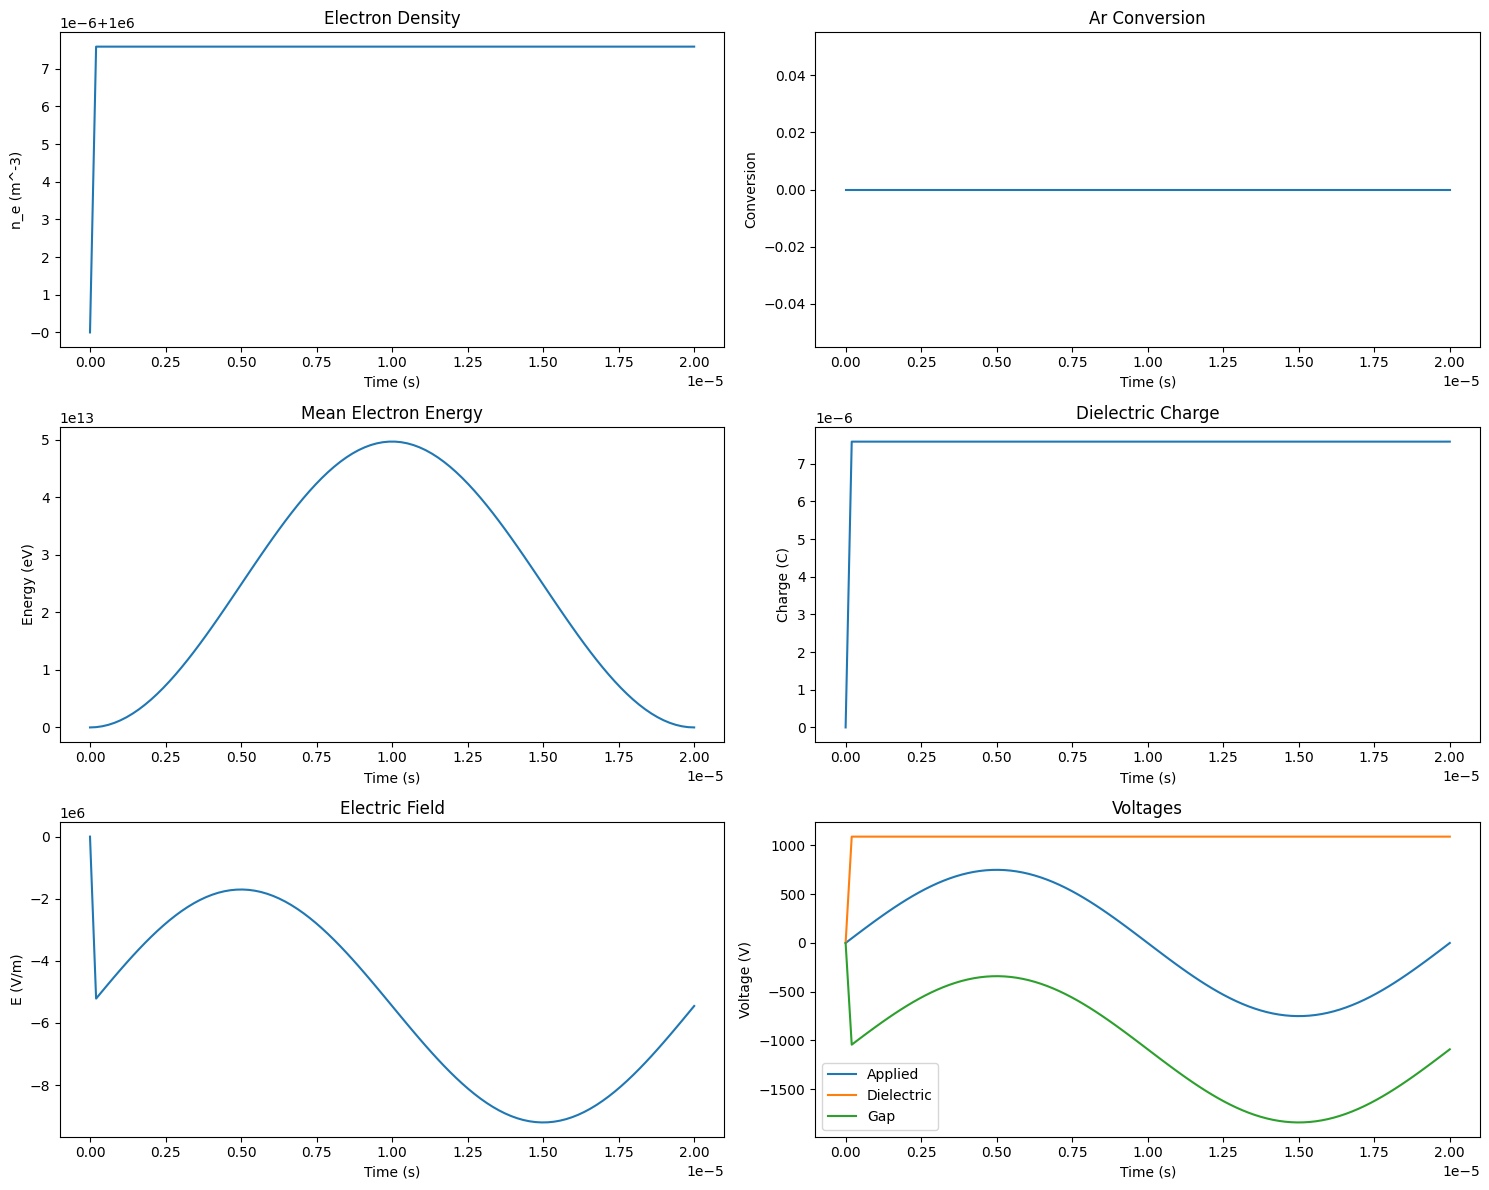

In [937]:
# 시간 그리드
t = np.linspace(0, 2e-5, 100)  # 시간 범위 확장

# 시뮬레이션 실행
sol = odeint(model, [n_e0, n_Ar0, n_Ars0, n_Ar1p0, E_mean0, Q_diel0], t)

# 결과 플로팅
plt.figure(figsize=(15, 12))

plt.subplot(321)
plt.plot(t, sol[:, 0])
plt.title('Electron Density')
plt.xlabel('Time (s)')
plt.ylabel('n_e (m^-3)')

plt.subplot(322)
plt.plot(t, 1 - sol[:, 1]/n_Ar0)
plt.title('Ar Conversion')
plt.xlabel('Time (s)')
plt.ylabel('Conversion')

plt.subplot(323)
plt.plot(t, sol[:, 4])
plt.title('Mean Electron Energy')
plt.xlabel('Time (s)')
plt.ylabel('Energy (eV)')

plt.subplot(324)
plt.plot(t, sol[:, 3])
plt.title('Dielectric Charge')
plt.xlabel('Time (s)')
plt.ylabel('Charge (C)')

plt.subplot(325)
V_applied = V0 * np.sin(w0 * t)
V_diel = sol[:, 3] / (eps0 * epsr * As / ddiel)
V_gap = V_applied - V_diel
E = V_gap / dgap
plt.plot(t, E)
plt.title('Electric Field')
plt.xlabel('Time (s)')
plt.ylabel('E (V/m)')

plt.subplot(326)
plt.plot(t, V_applied, label='Applied')
plt.plot(t, V_diel, label='Dielectric')
plt.plot(t, V_gap, label='Gap')
plt.title('Voltages')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()

plt.tight_layout()
plt.show()

In [938]:
sol[:, 4]

array([5.00000000e+00, 4.99992299e+10, 1.99795591e+11, 4.48785907e+11,
       7.95967579e+11, 1.23994263e+12, 1.77892333e+12, 2.41073943e+12,
       3.13284676e+12, 3.94233766e+12, 4.83595261e+12, 5.81009336e+12,
       6.86083738e+12, 7.98395370e+12, 9.17491990e+12, 1.04289404e+13,
       1.17409657e+13, 1.31057127e+13, 1.45176861e+13, 1.59712004e+13,
       1.74604028e+13, 1.89792967e+13, 2.05217662e+13, 2.20816002e+13,
       2.36525179e+13, 2.52281936e+13, 2.68022828e+13, 2.83684472e+13,
       2.99203803e+13, 3.14518330e+13, 3.29566387e+13, 3.44287382e+13,
       3.58622037e+13, 3.72512633e+13, 3.85903236e+13, 3.98739928e+13,
       4.10971019e+13, 4.22547260e+13, 4.33422037e+13, 4.43551561e+13,
       4.52895043e+13, 4.61414862e+13, 4.69076711e+13, 4.75849738e+13,
       4.81706670e+13, 4.86623924e+13, 4.90581700e+13, 4.93564061e+13,
       4.95558998e+13, 4.96558479e+13, 4.96558479e+13, 4.95558998e+13,
       4.93564060e+13, 4.90581699e+13, 4.86623922e+13, 4.81706668e+13,
      